# Predicting Face attractiveness
This notebook follows on this other notebook on analysing facial ratings. The previous notebook aimed to analyse how people rate a face ; we examined 
- the distribution of averages ratings across multiple pictures
- how several variables (gender and ethnicity) correlate with the ratings
- how individual raters rate different faces
- how different people rate a same face


In this notebook, our goal is to predict the attractiveness of faces using the MEBeauty dataset. We will explore the dataset, perform feature engineering, select appropriate models, and evaluate their performance. Ultimately, we aim to build a predictive model that can accurately estimate the attractiveness of faces based on various features.

## Objectives

The primary objectives of this notebook are:

1. **Dataset Exploration**: Gain a comprehensive understanding of the multi-ethnic dataset, including the distribution of attractiveness scores and the demographic characteristics of the subjects.
2. **Leveraging Pretrained Models**: Utilize a pretrained CNN to predict attractiveness scores, taking advantage of transfer learning to improve model performance.
3. **Model Selection and Training**: Fine-tune the pretrained CNN for our specific task and evaluate its performance.
4. **Explainability**: Ensure the model is interpretable so that we can understand which features it considers important for predicting attractiveness. This will lay the groundwork for identifying characteristic features of attractiveness in the next notebook.
5. **Practical Application**: Discuss potential applications of the predictive model and consider ethical implications. We will explore how this model can be used responsibly and the importance of avoiding biases.



By the end of this notebook, we aim to have a robust, explainable model that can predict the attractiveness of faces based on a diverse set of features. This model will provide insights into the factors that influence perceived attractiveness and demonstrate the potential of using deep learning for analyzing human perceptions.

## Preparing Data

In [46]:


import os
from pathlib import Path
from PIL import Image
import random

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from sklearn.preprocessing import StandardScaler
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split




In [47]:

link_data = "https://github.com/fbplab/MEBeauty-database/raw/main/scores/generic_scores_all_2022.xlsx"
df = pd.read_excel(link_data)
df = df.iloc[:, 0:3] #remove individual ratings
df

,mean,image,path
0,1.117647,kuma-kum-GKbPbR0ZAT4-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...
1,1.000000,pexels-cottonbro-5529905.jpg,/home/ubuntu/ME-beautydatabase/images/male/asi...
2,1.000000,pexels-nishant-aneja-2561432.jpg,/home/ubuntu/ME-beautydatabase/images/male/ind...
3,1.428571,woman-1929550_1920.jpg,NaN
4,1.500000,pexels-himesh-mehta-3059930.jpg,/home/ubuntu/ME-beautydatabase/images/female/i...
...,...,...,...
2602,9.000000,pexels-pixabay-247322.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...
2603,9.375000,women-5930352_1920.jpg,/home/ubuntu/ME-beautydatabase/images/female/a...
2604,9.222222,francesca-zama-1fhl_kmbfAE-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/h...
2605,9.625000,sofia--LNdco1UgNY-unsplash.jpg,/home/ubuntu/ME-beautydatabase/images/female/c...


In [48]:
# Drop  missing values if any
df.dropna(inplace=True)
df.drop("image", axis=1, inplace=True)

def standardize_path(cell):
    # We only want the architecture of the path from {gender}.
    # That way later we can provide whatever root path we want for the dataset
    path = Path(cell)
    return "/".join(path.parts[-3:])

df["path"] = df["path"].apply(standardize_path)

After removing the missing values, we have 2553 images. That's a lot of pictures ! Let's download them locally so that we can load them more easily later. You may take a cup of tea, this may take a while. Note that you may also only download the cropped dataset which is faster and takes less space on the machine.

In [49]:
import os
import requests
from tqdm import tqdm



# Function to download a file from a URL
def download_file(url, save_path):
    response = requests.get(url, stream=True)
    with open(save_path, 'wb') as file:
        for data in response.iter_content(chunk_size=1024):
            file.write(data)

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

def download_dataset(df, dataset_url, output_dir, rewrite=False):
    
    image_paths = df['path'].tolist()
    with tqdm(total=len(image_paths), unit='file') as pbar:
        for  path in image_paths:
            local_path = os.path.join(output_dir, path)
            if  rewrite or not os.path.isfile(local_path):
                write_dir = os.path.join(output_dir, *Path(path).parts[:-1])
                #print(write_dir)
                os.makedirs(write_dir, exist_ok=True)
                download_file(os.path.join(dataset_url , path), local_path)
            pbar.update(1)



In [50]:

# URLs of the images
base_url_original = 'https://github.com/fbplab/MEBeauty-database/raw/main/original_images/'
base_url_cropped = 'https://github.com/fbplab/MEBeauty-database/raw/main/cropped_images/images_crop_align_opencv/'

download_dataset(df, base_url_original, 'images/original', rewrite=False)

100%|█████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 10595.19file/s]


In [51]:
download_dataset(df, base_url_cropped, 'images/cropped', rewrite=False)

100%|██████████████████████████████████████████████████████████████████████████| 2553/2553 [00:00<00:00, 8622.35file/s]


Some of the images may be corrupted. Let's get rid of them before they cause us any problem downstream. It's ok, we have lots of them.

In [60]:
def is_image_loadable(image_path):
    try:
        img = Image.open(image_path)
        img.verify()  # Verify that it is, indeed an image
        return True
    except (IOError, SyntaxError) as e:
        print(f'Bad file: {image_path}')
        return False

def filter_corrupted_images(df, images_dir):
    df['full_path'] = df['path'].apply(lambda p: os.path.join(images_dir, p))
    df['is_valid'] = df['full_path'].apply(is_image_loadable)
    df_cleaned = df[df['is_valid']].drop(columns=['full_path', 'is_valid']).reset_index(drop=True)
    return df_cleaned


# Assuming your dataframe is named 'df' and the base path to your images is 'images_dir'
image_dir = 'images/original'
df_cleaned = filter_corrupted_images(df, image_dir )

# Check the number of images that were successfully loaded
print(f'Number of valid images: {len(df_cleaned)}')
print(f'Number of corrupted images removed: {len(df) - len(df_cleaned)}')

df = df_cleaned


Bad file: images/original\male/indian/puvvukonvict-photography-AtpSEe3yoIg-unsplash.jpg
Bad file: images/original\male/mideastern/imad-clicks-2_qmEnz7bQ4-unsplash.jpg
Bad file: images/original\female/indian/shifaaz-shamoon-MqLy-G-dBi8-unsplash.jpg
Bad file: images/original\male/black/payton-tuttle-n_RdRxH_7h4-unsplash.jpg
Bad file: images/original\male/hispanic/aryo-lahap-ZVc4Zg4TY8s-unsplash.jpg
Bad file: images/original\female/caucasian/brunette-2478405_1920.jpg
Bad file: images/original\male/caucasian/boy-1105361_1920.jpg
Bad file: images/original\male/caucasian/business-man-1385050_1920.jpg
Bad file: images/original\male/asian/tanjir-ahmed-chowdhury-YMJvX8k3Kfc-unsplash.jpg
Bad file: images/original\female/caucasian/creating-a-brand-WxAOdbDpMiU-unsplash.jpg
Bad file: images/original\male/caucasian/man-1488305_1920.jpg
Bad file: images/original\female/asian/pexels-rodnae-productions-4911184.jpg
Bad file: images/original\female/indian/brown-4197806_1920.jpg
Bad file: images/original\

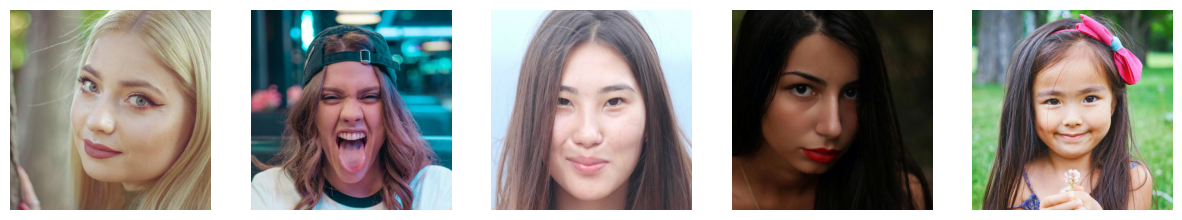

In [61]:
def load_images(dir:str, num_images:int=5)->list:
    '''
     loads a set number of random images within the directory 
    '''
    
    img_exts = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    image_paths = []
    assert os.path.isdir(dir)
    for root, dirs, files in os.walk(dir):
        for fname in files:
            if any(fname.lower().endswith(ext) for ext in img_exts):
                image_paths.append(os.path.join(root, fname))
    
    # Select a random subset of image paths
    num_images = min(num_images, len(image_paths))
                     
    selected_paths = random.sample(image_paths, num_images)
    images= []
    for image_path in selected_paths:
        image = Image.open(image_path).convert('RGB')
        images.append(image)
    
    return images

def display_images(images):
    plt.figure(figsize=(15, 5))
    for i, image in enumerate(images):
        plt.subplot(1, len(images), i+1)
        plt.imshow(image)
        plt.axis('off')  # Hide axes
    plt.show()


# Load a few  images of women
image_dir = 'images/original/female'
images = load_images(image_dir, num_images=5)

display_images(images)

## Loading Data
First we will split the dataset into : 
- training set (72%)  examples to train the model
- validation set (18%) to see how the model perform during training
- test set (10%), left untouched until we are content with our model. For final evaluation

In [67]:
image_dir = 'images/original/'
# Split the dataset into train/validation and test sets
train_val_df, test_df = train_test_split(df, test_size=0.1, random_state=42)

# Further split the train_val_df into training and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)

Since our dataset is made of images, and is quite large, it would be tedious to keep it in memory. Let's let up a dataloader to use it during training and swiftly access the images.

In [68]:
class AttractivenessDataset(Dataset):
    def __init__(self, dataframe, dataset_dir=".", transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.dataset_dir = dataset_dir

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.dataset_dir, self.dataframe.iloc[idx]['path'])
        image = Image.open(img_path).convert("RGB")
        label = self.dataframe.iloc[idx]['mean']
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)


In [69]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Datasets
train_dataset = AttractivenessDataset(train_df, image_dir, transform=transform)
val_dataset = AttractivenessDataset(val_df,  image_dir, transform=transform)
test_dataset = AttractivenessDataset(test_df,  image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Training the model 
Since the goal of this notebook is note to train a neural network from scratch but simply to , we are going to use a pre-trained CNN neural Network. Leveraging the knowledge gained by a pre-trained model on large image datasets, we hope to  easily capture the features of the faces in our dataset so as to find patterns with respect to the attractiveness scores. After several tests our final choice landed on MobileNetV2 : a lightweight pretrained Convolutional Neural Network (CNN) model for the following reasons :

- Size and Speed: This model is designed to be small and fast, making itsuitable for training on personal machines.
- Performance: Despite its size, it offers good performance for various computer vision tasks. It is reliable as it has been extensively by the community.
- Explainability: The model works well with explainability techniques suwhich can help us visualize the features that the model uses to make predictions. This will come into play in a later notebook.


Our task is a pretty straight-forward regression task where we try to predict scores between 1 and 10. Thus the choice of the Mean squared error as the loss function. We simply add a linear layer in place of the classification layer.

In [70]:
# Load the MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for regression
model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
# If the model has already been trained before or the training has been stopped before it ends we can simply reload it before resuming training

'''
'''

In [ ]:

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50, device='cuda'):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * images.size(0)

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.squeeze(), labels)
                val_loss += loss.item() * images.size(0)

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'models/best_model.pth')
    return train_losses, val_losses


#hyperparameters 
num_epochs = 50
lr = 1e-4

# Define the loss function for regression task and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


# Train the model
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


Epoch 1/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [05:04<00:00,  5.35s/it]


Epoch 1/50, Train Loss: 17.5231, Val Loss: 2.1111


Epoch 2/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [05:02<00:00,  5.31s/it]


Epoch 2/50, Train Loss: 1.2307, Val Loss: 1.0955


Epoch 3/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:53<00:00,  5.14s/it]


Epoch 3/50, Train Loss: 0.5990, Val Loss: 0.9227


Epoch 4/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [05:14<00:00,  5.51s/it]


Epoch 4/50, Train Loss: 0.4186, Val Loss: 1.0417


Epoch 5/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:29<00:00,  4.73s/it]


Epoch 5/50, Train Loss: 0.2909, Val Loss: 0.9679


Epoch 6/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:20<00:00,  4.57s/it]


Epoch 6/50, Train Loss: 0.2603, Val Loss: 0.9690


Epoch 7/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:49<00:00,  5.07s/it]


Epoch 7/50, Train Loss: 0.2148, Val Loss: 0.9662


Epoch 8/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:37<00:00,  4.87s/it]


Epoch 8/50, Train Loss: 0.1969, Val Loss: 0.9004


Epoch 9/50: 100%|██████████████████████████████████████████████████████████████████████| 57/57 [04:26<00:00,  4.68s/it]


Epoch 9/50, Train Loss: 0.1762, Val Loss: 0.9440


Epoch 10/50:  67%|█████████████████████████████████████████▎                    | 38/57 [2:55:35<11:31:11, 2182.73s/it]

Let's see how the training went. Since this is a regression task, we don't need any accuracy metrics. Our final objective is the same as the optimization goal given to the model (or rather its inverse) that is : minimizing the Mean square error, or in other words : we want our predicted scores to be the closest possible to the real scores. We will plot the Mean Squared Error for the training set and for the validation set.

In [58]:
# Plot the performance evolution
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'num_epochs' is not defined

<Figure size 1000x500 with 0 Axes>

## Evaluation
At last, once we are content with are model, let's see our it performs on unseen data.

In [ ]:

def evaluate_model(model, test_loader, criterion, device='cuda'):
    model.load_state_dict(torch.load('best_model.pth'))
    model.eval()
    
    test_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device